# qPCR Processing and Plotting Pipeline (Final Fixed)

This notebook handles qPCR data processing and multi-primer comparative plotting. It automatically normalizes data against a reference primer and baseline condition specified in each row.

In [9]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

sns.set(color_codes=True, style="white")
pd.options.mode.chained_assignment = None

## 1. Data Processing Logic

In [10]:
def process_qpcr_csv(file_path):
    df = pd.read_csv(file_path)
    metadata_cols = ['Condition', 'Primer_ref', 'FoldChange_ref']
    available_primers = [c for c in df.columns if c not in metadata_cols]

    # Improved regex: removes trailing space+digit OR just trailing digit
    # Handles 'WT, diff. 1' -> 'WT, diff.' AND 'res GFP 1' -> 'res GFP'
    df['BaseCondition'] = df['Condition'].apply(lambda x: re.sub(r'\s*\d+$', '', str(x)).strip())

    # dCp
    for primer in available_primers:
        dcp_col = f'dCp_{primer}'
        df[dcp_col] = df.apply(lambda row: row[primer] - row[row['Primer_ref']], axis=1)

    # ddCp & FoldChange
    for primer in available_primers:
        dcp_col = f'dCp_{primer}'
        ddcp_col = f'ddCp_{primer}'
        fc_col = f'FoldChange_{primer}'

        def calc_ddcp(row):
            ref_condition = str(row['FoldChange_ref']).strip()
            ref_mask = df['BaseCondition'] == ref_condition
            if not ref_mask.any():
                # Backup: check if it's exact match in Condition if BaseCondition fails
                ref_mask = df['Condition'].astype(str).str.startswith(ref_condition)

            if not ref_mask.any():
                return np.nan

            ref_mean = df[ref_mask][dcp_col].mean()
            return row[dcp_col] - ref_mean

        df[ddcp_col] = df.apply(calc_ddcp, axis=1)
        df[fc_col] = 2 ** (-df[ddcp_col])

    # Filter redundant columns
    cols_to_drop = []
    for primer in available_primers:
        if (df[f'dCp_{primer}'] == 0).all():
            cols_to_drop.extend([f'dCp_{primer}', f'ddCp_{primer}', f'FoldChange_{primer}'])

    df_final = df.drop(columns=cols_to_drop)
    target_primers = [p for p in available_primers if f'FoldChange_{p}' in df_final.columns]

    output_path = file_path.replace('.csv', '-processed.csv')
    df_final.to_csv(output_path, index=False)
    return df_final, target_primers

## 2. Final Plotting Logic

In [11]:
def plot_final_results(df, target_primers, condition_order, primer_order, save_tag, save_folder):
    metrics = [('dCp', 'dCp Value'), ('ddCp', 'ddCp Value'), ('FoldChange', 'Fold Change')]

    # Dynamic Figure Size calculation
    # Width = 1.2 per condition group + legend space
    num_conds = len(condition_order) if condition_order else len(df['BaseCondition'].unique())
    width = max(4, num_conds * 1.5)
    figsize = (width, 4)

    for metric_prefix, ylabel in metrics:
        # Melt for categorical plotting
        cols = [f'{metric_prefix}_{p}' for p in target_primers]
        id_cols = [c for c in df.columns if not any(c.startswith(pre) for pre in ['dCp_', 'ddCp_', 'FoldChange_'])]
        plot_df = df[id_cols + cols].melt(id_vars=id_cols, value_vars=cols, var_name='Primer', value_name='val')
        plot_df['Primer'] = plot_df['Primer'].str.replace(f'{metric_prefix}_', '')

        plt.figure(figsize=figsize)
        ax = sns.barplot(
            data=plot_df,
            x="BaseCondition",
            y="val",
            hue="Primer",
            hue_order=primer_order,
            order=condition_order,
            palette="tab10",
            errorbar=("ci", 95),
            capsize=0.5,
            alpha=0.8
        )

        sns.swarmplot(
            data=plot_df,
            x="BaseCondition",
            y="val",
            hue="Primer",
            hue_order=primer_order,
            order=condition_order,
            dodge=True,
            color="black",
            alpha=0.6,
            legend=False
        )

        plt.ylabel(ylabel, fontsize=14)
        plt.xlabel("")
        plt.xticks(rotation=30, ha='right')
        plt.legend(title="Primer", bbox_to_anchor=(1.03, 1), loc='upper left', frameon=False)
        plt.gca().spines[:].set_linewidth(1)
        plt.gca().tick_params(axis="both", which="major", labelsize=12, direction="in", bottom=True, left=True, length=5, width=1)

        plt.savefig(os.path.join(save_folder, f"{save_tag}_{metric_prefix}.png"), dpi=300, bbox_inches='tight')
        plt.show()

## 3. Execute Pipeline

/var/folders/99/zzxtlty93nzffj9nq54dd7wr0000gn/T/ipykernel_92018/2188605221.py:31: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.swarmplot(


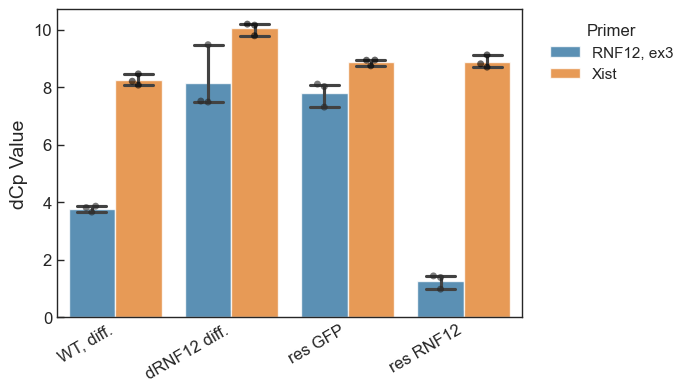

/var/folders/99/zzxtlty93nzffj9nq54dd7wr0000gn/T/ipykernel_92018/2188605221.py:31: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.swarmplot(


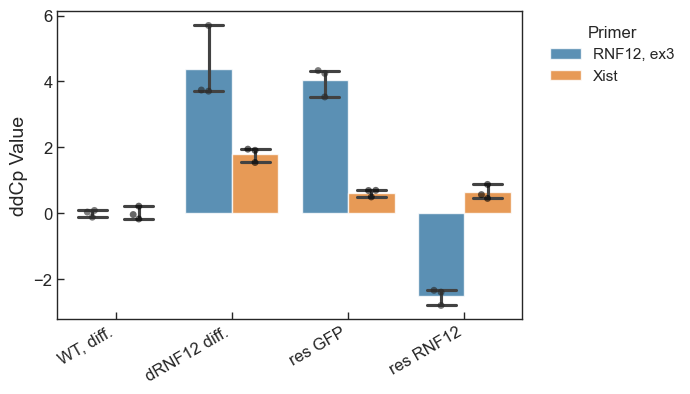

/var/folders/99/zzxtlty93nzffj9nq54dd7wr0000gn/T/ipykernel_92018/2188605221.py:31: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.swarmplot(


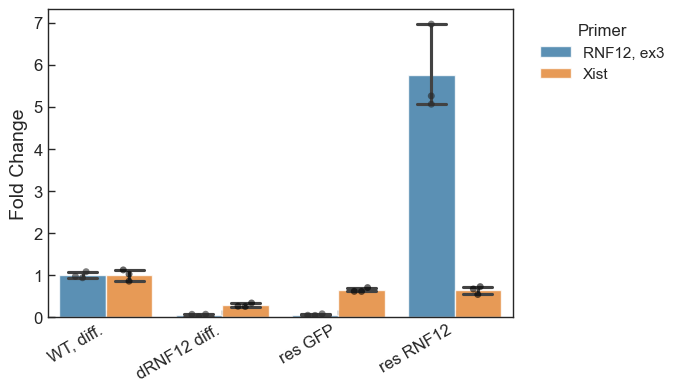

In [12]:
data_dir = "/Volumes/guttman/users/gmgao/Data_qPCR/20260115-3exps"

rnf_df, rnf_primers = process_qpcr_csv(os.path.join(data_dir, "20260115-RNF12rescue.csv"))
plot_final_results(rnf_df, rnf_primers,
                   condition_order=["WT, diff.", "dRNF12 diff.", "res GFP", "res RNF12"],
                   primer_order=["RNF12, ex3", "Xist"],
                   save_tag="RNF12rescue20260115", save_folder=data_dir)